In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 1

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 3s 28ms/step - loss: 0.6682 - accuracy: 0.7544 - val_loss: 0.6487 - val_accuracy: 0.7367
Epoch 2/200
99/99 [==============================] - ETA: 0s - loss: 0.6263 - accuracy: 0.7544
Epoch 00002: val_loss improved from inf to 0.61856, saving model to best_model_2.h5
99/99 [==============================] - 3s 26ms/step - loss: 0.6263 - accuracy: 0.7544 - val_loss: 0.6186 - val_accuracy: 0.7367
Epoch 3/200
97/99 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.7545
Epoch 00003: val_loss improved from 0.61856 to 0.60062, saving model to best_model_2.h5
99/99 [==============================] - 3s 26ms/step - loss: 0.5983 - accuracy: 0.7544 - val_loss: 0.6006 - val_accuracy: 0.7367
Epoch 4/200
99/99 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7544
Epoch 00004: val_loss improved from 0.60062 to 0.59157, saving model to best_model_2.h5
99/99 [==============================] - 3s 26ms/step

Epoch 28/200
99/99 [==============================] - ETA: 0s - loss: 0.5178 - accuracy: 0.7541
Epoch 00028: val_loss improved from 0.53265 to 0.52654, saving model to best_model_2.h5
99/99 [==============================] - 4s 42ms/step - loss: 0.5178 - accuracy: 0.7541 - val_loss: 0.5265 - val_accuracy: 0.7443
Epoch 29/200
99/99 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.7563
Epoch 00029: val_loss improved from 0.52654 to 0.51980, saving model to best_model_2.h5
99/99 [==============================] - 4s 41ms/step - loss: 0.5098 - accuracy: 0.7563 - val_loss: 0.5198 - val_accuracy: 0.7452
Epoch 30/200
98/99 [============================>.] - ETA: 0s - loss: 0.5020 - accuracy: 0.7573
Epoch 00030: val_loss improved from 0.51980 to 0.51130, saving model to best_model_2.h5
99/99 [==============================] - 4s 42ms/step - loss: 0.5019 - accuracy: 0.7576 - val_loss: 0.5113 - val_accuracy: 0.7490
Epoch 31/200
99/99 [==============================] - ETA:

Epoch 55/200
99/99 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9369
Epoch 00055: val_loss improved from 0.19623 to 0.19131, saving model to best_model_2.h5
99/99 [==============================] - 6s 58ms/step - loss: 0.1864 - accuracy: 0.9369 - val_loss: 0.1913 - val_accuracy: 0.9439
Epoch 56/200
98/99 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9397
Epoch 00056: val_loss improved from 0.19131 to 0.18687, saving model to best_model_2.h5
99/99 [==============================] - 6s 58ms/step - loss: 0.1767 - accuracy: 0.9398 - val_loss: 0.1869 - val_accuracy: 0.9382
Epoch 57/200
98/99 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9381
Epoch 00057: val_loss did not improve from 0.18687
99/99 [==============================] - 6s 59ms/step - loss: 0.1796 - accuracy: 0.9385 - val_loss: 0.2109 - val_accuracy: 0.9221
Epoch 58/200
99/99 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9417

Epoch 83/200
99/99 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.9550
Epoch 00083: val_loss did not improve from 0.14342
99/99 [==============================] - 6s 59ms/step - loss: 0.1344 - accuracy: 0.9550 - val_loss: 0.1529 - val_accuracy: 0.9420
Epoch 84/200
98/99 [============================>.] - ETA: 0s - loss: 0.1295 - accuracy: 0.9589
Epoch 00084: val_loss did not improve from 0.14342
99/99 [==============================] - 6s 58ms/step - loss: 0.1297 - accuracy: 0.9588 - val_loss: 0.1612 - val_accuracy: 0.9344
Epoch 85/200
98/99 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9541
Epoch 00085: val_loss did not improve from 0.14342
99/99 [==============================] - 6s 58ms/step - loss: 0.1362 - accuracy: 0.9537 - val_loss: 0.1483 - val_accuracy: 0.9458
Epoch 86/200
99/99 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9518
Epoch 00086: val_loss did not improve from 0.14342
99/99 [===============

98/99 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9621
Epoch 00111: val_loss did not improve from 0.12449
99/99 [==============================] - 6s 60ms/step - loss: 0.1075 - accuracy: 0.9620 - val_loss: 0.1776 - val_accuracy: 0.9278
Epoch 112/200
98/99 [============================>.] - ETA: 0s - loss: 0.1225 - accuracy: 0.9557
Epoch 00112: val_loss did not improve from 0.12449
99/99 [==============================] - 6s 59ms/step - loss: 0.1224 - accuracy: 0.9556 - val_loss: 0.1255 - val_accuracy: 0.9591
Epoch 113/200
98/99 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9592
Epoch 00113: val_loss did not improve from 0.12449
99/99 [==============================] - 6s 59ms/step - loss: 0.1148 - accuracy: 0.9594 - val_loss: 0.1372 - val_accuracy: 0.9430
Epoch 114/200
99/99 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9620
Epoch 00114: val_loss improved from 0.12449 to 0.12357, saving model to best_model_

Epoch 140/200
99/99 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9636
Epoch 00140: val_loss did not improve from 0.10526
99/99 [==============================] - 5s 55ms/step - loss: 0.0994 - accuracy: 0.9636 - val_loss: 0.1113 - val_accuracy: 0.9525
Epoch 141/200
98/99 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9646
Epoch 00141: val_loss improved from 0.10526 to 0.10236, saving model to best_model_2.h5
99/99 [==============================] - 6s 56ms/step - loss: 0.0889 - accuracy: 0.9648 - val_loss: 0.1024 - val_accuracy: 0.9639
Epoch 142/200
98/99 [============================>.] - ETA: 0s - loss: 0.0975 - accuracy: 0.9640
Epoch 00142: val_loss did not improve from 0.10236
99/99 [==============================] - 5s 54ms/step - loss: 0.0972 - accuracy: 0.9642 - val_loss: 0.1056 - val_accuracy: 0.9629
Epoch 143/200
98/99 [============================>.] - ETA: 0s - loss: 0.0908 - accuracy: 0.9672
Epoch 00143: val_loss did not im

Epoch 169/200
98/99 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9719
Epoch 00169: val_loss did not improve from 0.09316
99/99 [==============================] - 5s 49ms/step - loss: 0.0750 - accuracy: 0.9715 - val_loss: 0.0935 - val_accuracy: 0.9658
Epoch 170/200
99/99 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9712
Epoch 00170: val_loss did not improve from 0.09316
99/99 [==============================] - 5s 50ms/step - loss: 0.0803 - accuracy: 0.9712 - val_loss: 0.1410 - val_accuracy: 0.9458
Epoch 171/200
99/99 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9737
Epoch 00171: val_loss did not improve from 0.09316
99/99 [==============================] - 5s 49ms/step - loss: 0.0762 - accuracy: 0.9737 - val_loss: 0.1114 - val_accuracy: 0.9515
Epoch 172/200
98/99 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9688
Epoch 00172: val_loss did not improve from 0.09316
99/99 [===========

99/99 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9734
Epoch 00198: val_loss did not improve from 0.08915
99/99 [==============================] - 4s 40ms/step - loss: 0.0750 - accuracy: 0.9734 - val_loss: 0.0937 - val_accuracy: 0.9667
Epoch 199/200
99/99 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9737
Epoch 00199: val_loss improved from 0.08915 to 0.08698, saving model to best_model_2.h5
99/99 [==============================] - 4s 39ms/step - loss: 0.0677 - accuracy: 0.9737 - val_loss: 0.0870 - val_accuracy: 0.9677
Epoch 200/200
99/99 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9750
Epoch 00200: val_loss did not improve from 0.08698
99/99 [==============================] - 4s 40ms/step - loss: 0.0610 - accuracy: 0.9750 - val_loss: 0.0876 - val_accuracy: 0.9667
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #

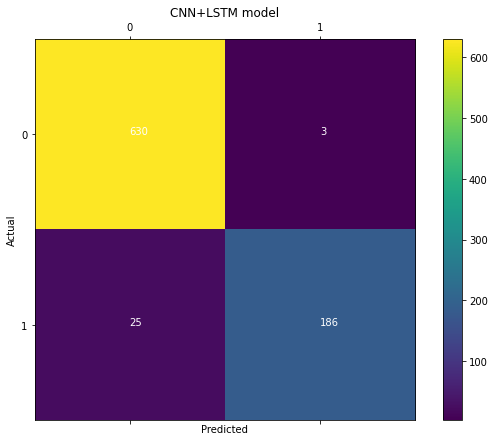

val_loss: 0.08698280900716782
test_loss: 0.11581133306026459
test_acc: 0.9668246507644653
precision: 0.9841269841269841
recall: 0.8815165876777251
specificity 0.995260663507109
sensitivity :  0.8815165876777251
far 0.004739336492890996
frr 0.11848341232227488


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 154, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 190, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
conv_3 = tf.keras.layers.Conv1D(filters = 18, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.4476962408598348)(max_3)
    
    
lstm_1 = tf.keras.layers.LSTM(200)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(174, activation = 'relu')(lstm_1)
dense_2 = tf.keras.layers.Dense(36, activation = 'relu')(dense_1)
dense_3 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_2)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_3)

# Adam
# model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0013958364080478966), metrics = ['accuracy'])
# SGD
model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.0003045598974602239, momentum=0.8915087720100587), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)